In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_excel("Bird_Mortality_In_Windfarms.xlsx", sheet_name="crossings")

# Binary target
df["Target"] = df["Activity"].apply(lambda x: 1 if str(x).lower()=="flying" else 0)

drop_cols = ["Activity","Target","sn","id","date"]
drop_cols = [c for c in drop_cols if c in df.columns]

X = df[[c for c in df.columns if c not in drop_cols]]
y = df["Target"]

# 70/30 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("Done base setup.")


Done base setup.


In [ ]:

# LOGISTIC REGRESSION ONLY

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve


df["Target"] = df["Activity"].apply(
    lambda x: 1 if str(x).lower()=="flying" else 0
)

drop_cols = ["Activity","Target","sn","id","date"]
drop_cols = [c for c in drop_cols if c in df.columns]
X = df[[c for c in df.columns if c not in drop_cols]]
y = df["Target"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)


numeric = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical = X_train.select_dtypes(include=["object"]).columns.tolist()

preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
])

pipe_lr = Pipeline([
    ("preprocess", preprocess),
    ("lr", LogisticRegression(max_iter=5000, solver="lbfgs"))
])


pipe_lr = Pipeline([
    ("preprocess", preprocess),
    ("lr", LogisticRegression(max_iter=1000))
])

pipe_lr.fit(X_train, y_train)


y_pred = pipe_lr.predict(X_test)
y_prob = pipe_lr.predict_proba(X_test)[:,1]

print("\n=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


print("Train Accuracy:", pipe_lr.score(X_train, y_train))
print("Test Accuracy :", pipe_lr.score(X_test, y_test))


fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob)
auc_lr = roc_auc_score(y_test, y_prob)



=== Logistic Regression ===
Accuracy: 0.7606382978723404
AUC: 0.8307465730146143
              precision    recall  f1-score   support

           0       0.76      0.78      0.77        97
           1       0.76      0.74      0.75        91

    accuracy                           0.76       188
   macro avg       0.76      0.76      0.76       188
weighted avg       0.76      0.76      0.76       188

Train Accuracy: 0.8073394495412844
Test Accuracy : 0.7606382978723404


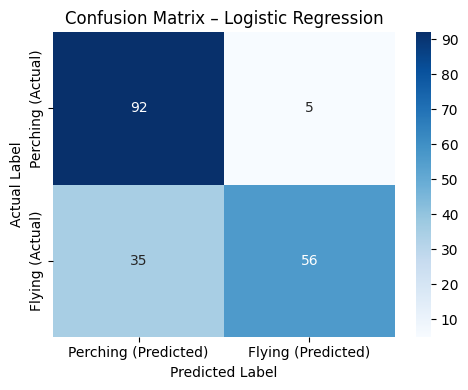

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Perching (Predicted)", "Flying (Predicted)"],
    yticklabels=["Perching (Actual)", "Flying (Actual)"]
)

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix – Logistic Regression")
plt.tight_layout()
plt.show()


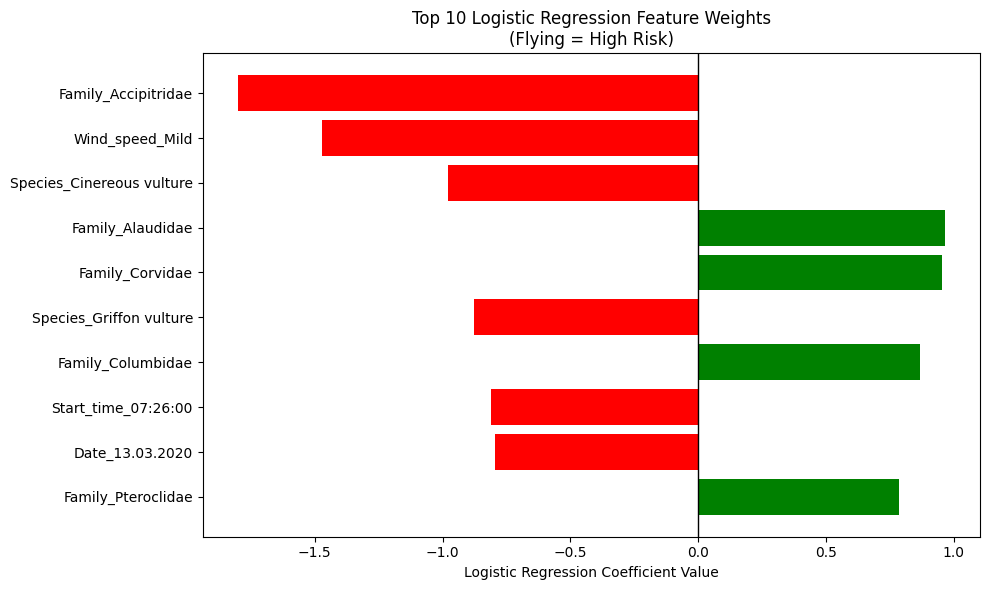

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


pre = pipe_lr.named_steps["preprocess"]
lr  = pipe_lr.named_steps["lr"]


numeric_features = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()

ohe = pre.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

feature_names = numeric_features + list(cat_feature_names)


coefficients = lr.coef_[0]

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})


coef_df["AbsCoefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="AbsCoefficient", ascending=False)

top10 = coef_df.head(10)

plt.figure(figsize=(10,6))
colors = ["green" if c > 0 else "red" for c in top10["Coefficient"]]

plt.barh(top10["Feature"], top10["Coefficient"], color=colors)
plt.axvline(0, color="black", linewidth=1)

plt.xlabel("Logistic Regression Coefficient Value")
plt.title("Top 10 Logistic Regression Feature Weights\n(Flying = High Risk)")

plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()



In [ ]:

pre = pipe_lr.named_steps["preprocess"]
lr  = pipe_lr.named_steps["lr"]

print("\n=== NUMERIC FEATURES (before encoding) ===")
print(numeric)

print("\n=== CATEGORICAL FEATURES (before encoding) ===")
print(categorical)

ohe = pre.named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(categorical)

all_feature_names = list(numeric) + list(ohe_feature_names)

print("\n=== FINAL TRANSFORMED FEATURE NAMES USED ===")
for f in all_feature_names:
    print(f)

coeffs = lr.coef_[0]
intercept = lr.intercept_[0]

weights = pd.DataFrame({
    "feature": all_feature_names,
    "weight": coeffs
}).sort_values(by="weight", key=abs, ascending=False)

print("\n=== LOGISTIC REGRESSION WEIGHTS (sorted) ===")
print(weights)

print("\nIntercept:", intercept)



=== NUMERIC FEATURES (before encoding) ===
['SN', 'ID', 'Radius', 'Obs_WT_dist', 'WT_ht', 'Individuals', 'H_min', 'H_max', 'Mid_height', 'D_min', 'D_max', 'mid_dist']

=== CATEGORICAL FEATURES (before encoding) ===
['Type', 'Land-Cover', 'Terrain', 'Substrate', 'Date', 'Start_time', 'End_time', 'Blade_length', 'Wind_speed', 'Species', 'Family']

=== FINAL TRANSFORMED FEATURE NAMES USED ===
SN
ID
Radius
Obs_WT_dist
WT_ht
Individuals
H_min
H_max
Mid_height
D_min
D_max
mid_dist
Type_Cluster
Type_Single
Land-Cover_Barren
Land-Cover_Grassland
Land-Cover_Shrubland
Terrain_Flat
Terrain_Moderate Undulating
Terrain_Moderate flat
Terrain_Moderate undulating
Terrain_Slop
Terrain_Very Undulating
Terrain_Very undulating
Substrate_Gravel
Substrate_Rocky
Substrate_Rocky gravel
Substrate_Sandy
Date_06.03.2020
Date_07.03.2020
Date_08.03.2020
Date_08.04.2020
Date_11.03.2020
Date_12.03.2020
Date_13.03.2020
Date_14.03.2020
Date_15.03.2020
Date_17.03.2020
Date_18.03.2020
Date_19.03.2020
Date_20.03.2020
Da


=== Decision Tree Results ===
Accuracy: 0.7872340425531915
AUC: 0.835504701484083

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.95      0.82        97
           1       0.92      0.62      0.74        91

    accuracy                           0.79       188
   macro avg       0.82      0.78      0.78       188
weighted avg       0.82      0.79      0.78       188


Confusion Matrix:
 [[92  5]
 [35 56]]


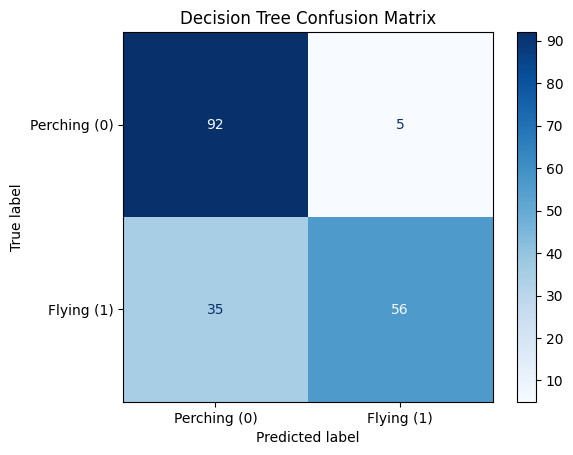


=== Overfitting Check ===
Train Accuracy: 0.8348623853211009
Test Accuracy : 0.7872340425531915


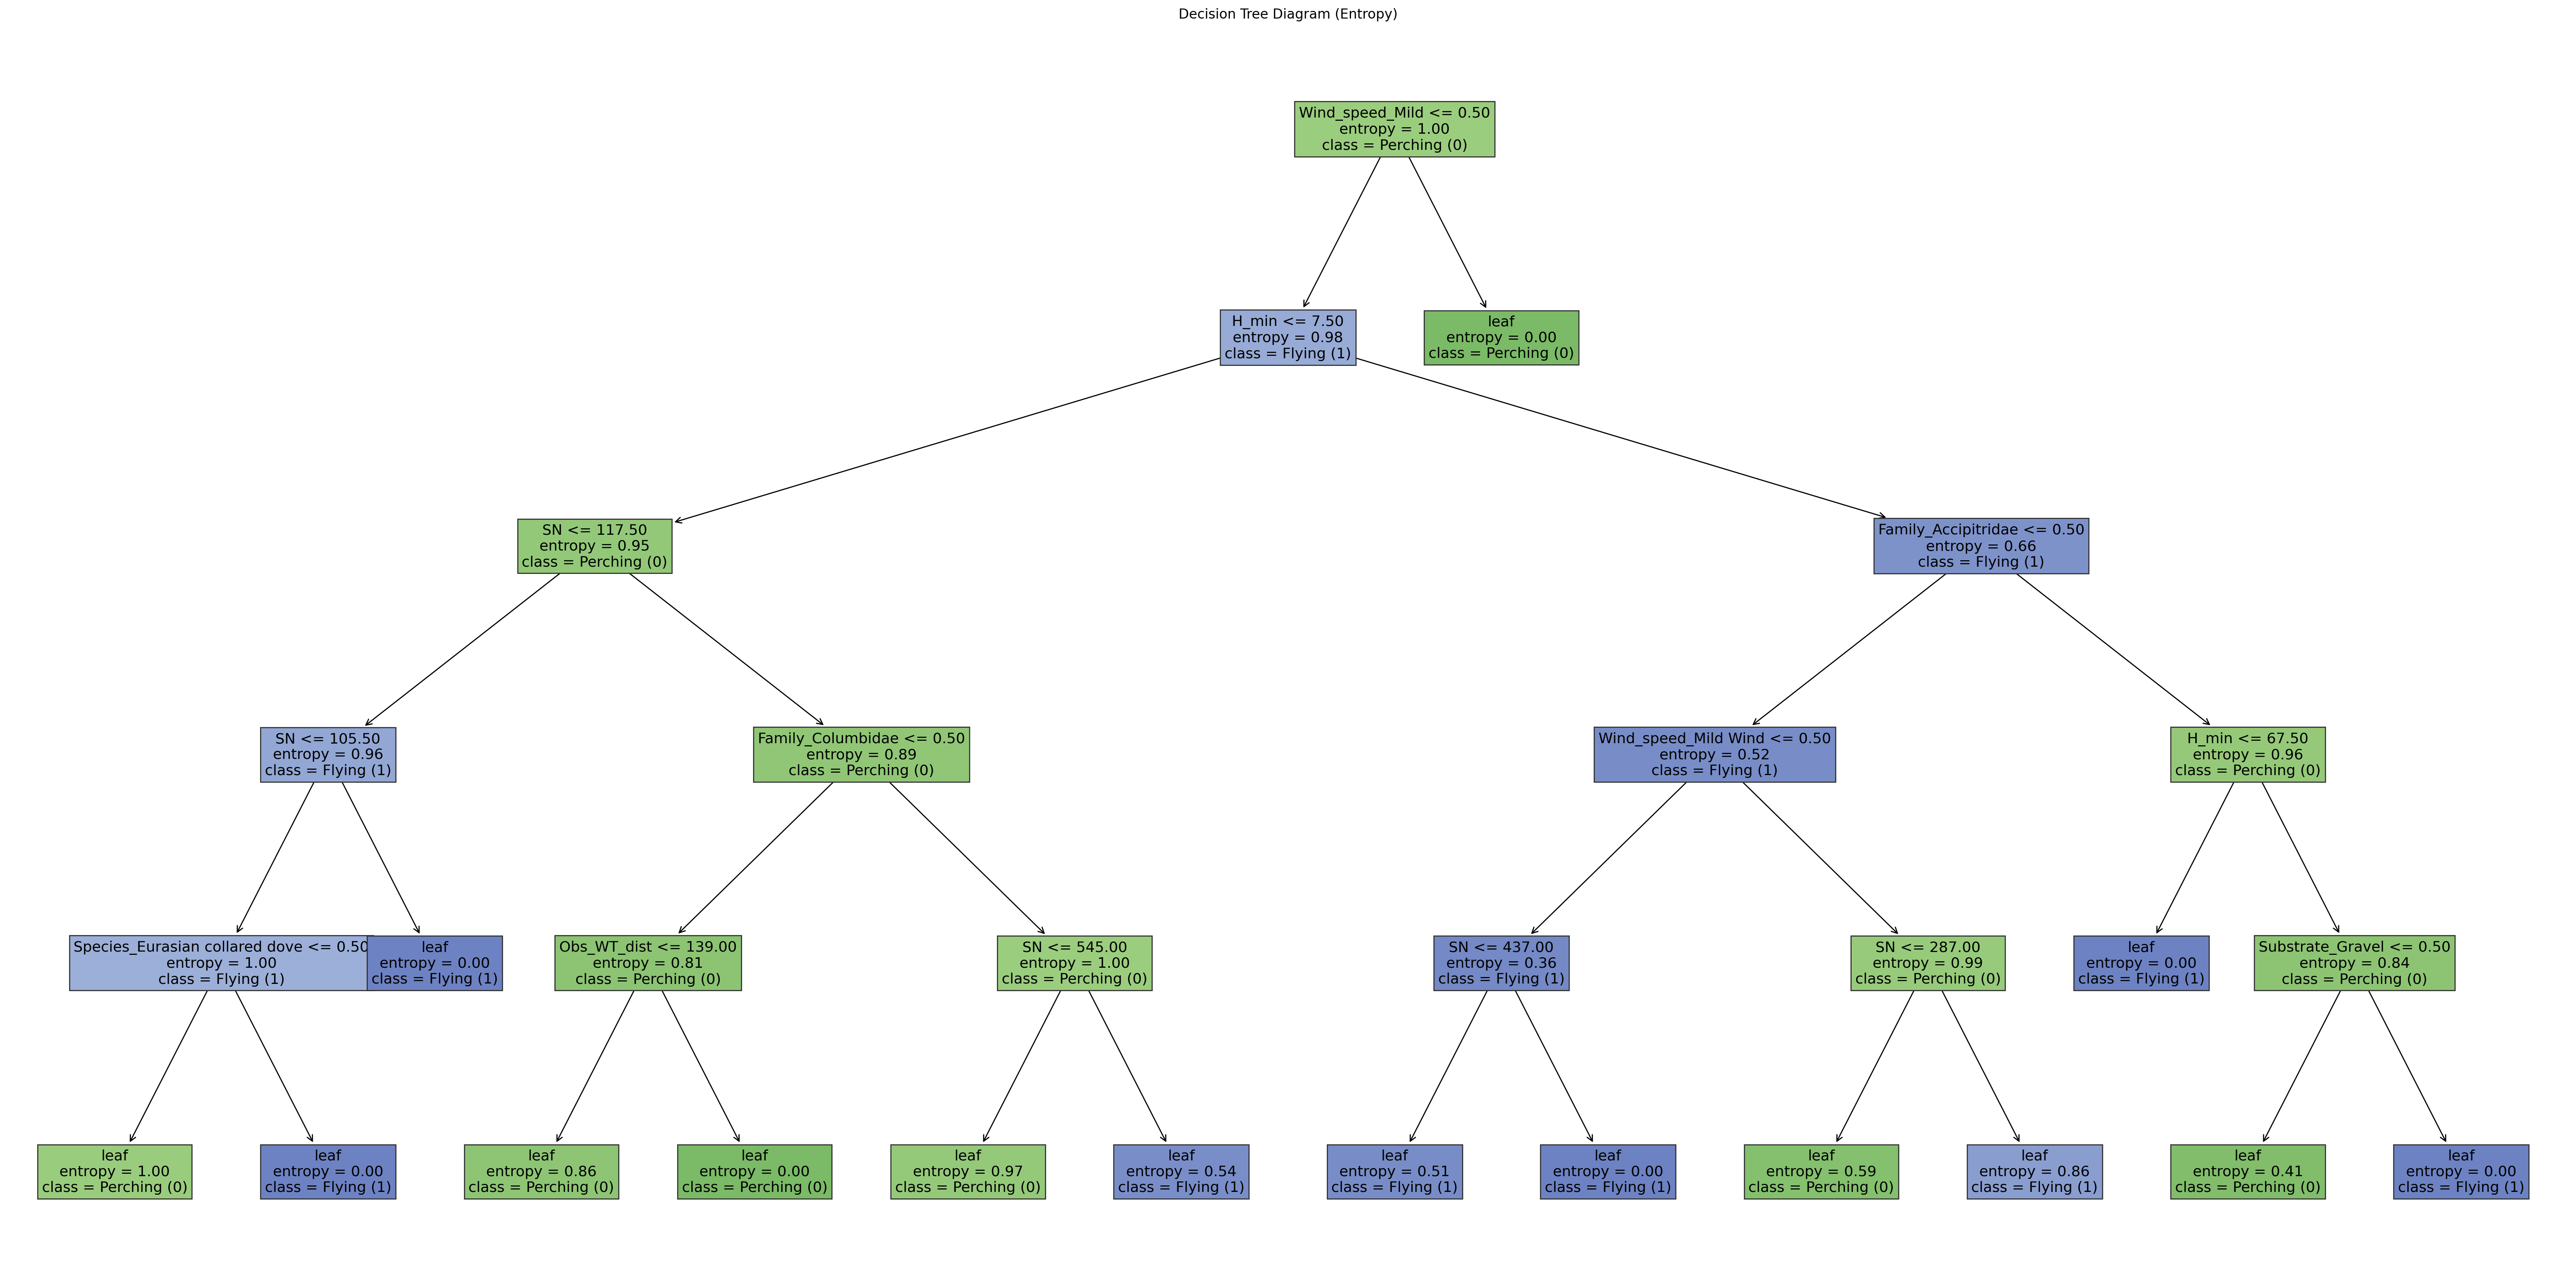

In [ ]:

# DECISION TREE CLASSIFIER (Flying = High Risk, Perching=Low)


import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

df["Target"] = df["Activity"].apply(
    lambda x: 1 if str(x).lower()=="flying" else 0
)


drop_cols = ["Activity","Target","sn","id","date"]
drop_cols = [c for c in drop_cols if c in df.columns]

X = df[[c for c in df.columns if c not in drop_cols]]
y = df["Target"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)


numeric = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical = X_train.select_dtypes(include=["object"]).columns.tolist()

preprocess = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), numeric),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
])


pipe_dt = Pipeline([
    ("preprocess", preprocess),
    ("dt", DecisionTreeClassifier(
        criterion="entropy",   
        max_depth=5,          
        random_state=42
    ))
])


pipe_dt.fit(X_train, y_train)


y_pred = pipe_dt.predict(X_test)
y_prob = pipe_dt.predict_proba(X_test)[:,1]

print("\n=== Decision Tree Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Perching (0)", "Flying (1)"])
disp.plot(cmap="Blues")
plt.title("Decision Tree Confusion Matrix")
plt.show()


print("\n=== Overfitting Check ===")
print("Train Accuracy:", pipe_dt.score(X_train, y_train))
print("Test Accuracy :", pipe_dt.score(X_test, y_test))


fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob)
auc_dt = roc_auc_score(y_test, y_prob)

dt_model = pipe_dt.named_steps["dt"]

from sklearn.tree import _tree
import re

feature_names = list(numeric) + list(pipe_dt.named_steps["preprocess"]
                                     .named_transformers_["cat"]
                                     .get_feature_names_out(categorical))
class_names = ["Perching (0)", "Flying (1)"]

fig, ax = plt.subplots(figsize=(32,16), dpi=200)
texts = plot_tree(
    dt_model,
    filled=False,
    feature_names=feature_names,
    class_names=class_names,
    node_ids=True,
    label="none",
    impurity=False,
    proportion=False,
    rounded=False,
    ax=ax,
    precision=2,
    fontsize=13,
)

tr = dt_model.tree_
for t in texts:
    text = t.get_text().strip()
    if not text:
        continue
    first_line = text.splitlines()[0]
    m = re.search(r"(\d+)", first_line)
    if not m:
        t.set_text("")
        continue
    node_id = int(m.group(1))
    entropy = tr.impurity[node_id]
    if tr.feature[node_id] != _tree.TREE_UNDEFINED:
        name = feature_names[tr.feature[node_id]]
        threshold = tr.threshold[node_id]
        attr = f"{name} <= {threshold:.2f}"
    else:
        attr = "leaf"
    counts = tr.value[node_id][0]
    total = counts.sum() if counts.sum() != 0 else 1.0
    p0 = counts[0] / total
    p1 = counts[1] / total
    class_idx = counts.argmax()
    class_name = class_names[class_idx]
    if p0 >= p1:
        color = mix(perch_light, perch_dark, p0)
    else:
        color = mix(fly_light, fly_dark, p1)
    t.set_text(f"{attr}\nentropy = {entropy:.2f}\nclass = {class_name}")
    t.set_fontsize(13)
    t.set_bbox(dict(facecolor=color, edgecolor="#333333", boxstyle="square,pad=0.3", linewidth=1.0))



def hex_to_rgb(h):
    h = h.lstrip("#")
    return tuple(int(h[i:i+2], 16) / 255.0 for i in (0, 2, 4))


def mix(c1, c2, t):
    return tuple(c1[i] + (c2[i] - c1[i]) * t for i in range(3))

perch_light = hex_to_rgb("#bde198")
perch_dark = hex_to_rgb("#7bba66")
fly_light = hex_to_rgb("#cfe2f0")
fly_dark = hex_to_rgb("#6d82c2")

plt.title("Decision Tree Diagram (Entropy)")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.tree import export_text

dt_model = pipe_dt.named_steps["dt"]

ohe = pipe_dt.named_steps["preprocess"].named_transformers_['cat']
cat_names = ohe.get_feature_names_out(categorical)

feature_names = list(numeric) + list(cat_names)

print("\n=== DECISION TREE RULES (TEXT) ===")
print(export_text(dt_model, feature_names=feature_names))



=== DECISION TREE RULES (TEXT) ===
|--- Wind_speed_Mild <= 0.50
|   |--- H_min <= 7.50
|   |   |--- SN <= 117.50
|   |   |   |--- SN <= 105.50
|   |   |   |   |--- Species_Eurasian collared dove <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Species_Eurasian collared dove >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- SN >  105.50
|   |   |   |   |--- class: 1
|   |   |--- SN >  117.50
|   |   |   |--- Family_Columbidae <= 0.50
|   |   |   |   |--- Obs_WT_dist <= 139.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Obs_WT_dist >  139.00
|   |   |   |   |   |--- class: 0
|   |   |   |--- Family_Columbidae >  0.50
|   |   |   |   |--- SN <= 545.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- SN >  545.00
|   |   |   |   |   |--- class: 1
|   |--- H_min >  7.50
|   |   |--- Family_Accipitridae <= 0.50
|   |   |   |--- Wind_speed_Mild Wind <= 0.50
|   |   |   |   |--- SN <= 437.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- SN >  4

In [ ]:

# NEURAL NETWORK (Flying vs Perching)

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve


df["Target"] = df["Activity"].apply(
    lambda x: 1 if str(x).lower()=="flying" else 0
)

drop_cols = ["Activity","Target","sn","id","date"]
drop_cols = [c for c in drop_cols if c in df.columns]

X = df[[c for c in df.columns if c not in drop_cols]]
y = df["Target"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)


numeric = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
categorical = X_train.select_dtypes(include=["object"]).columns.tolist()

preprocess = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), numeric),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
])


pipe_nn = Pipeline([
    ("preprocess", preprocess),
    ("nn", MLPClassifier(
        hidden_layer_sizes=(16,8),   
        activation="relu",
        solver="adam",
        max_iter=1000,
        random_state=42
    ))
])

pipe_nn.fit(X_train, y_train)

y_pred = pipe_nn.predict(X_test)
y_prob = pipe_nn.predict_proba(X_test)[:,1]

print("\n=== Neural Network Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

print("\n=== Overfitting Check ===")
print("Train Accuracy:", pipe_nn.score(X_train, y_train))
print("Test Accuracy :", pipe_nn.score(X_test, y_test))

fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob)
auc_nn = roc_auc_score(y_test, y_prob)


nn_model = pipe_nn.named_steps["nn"]

print("\n=== Neural Network Architecture ===")
print("Hidden layers:", nn_model.hidden_layer_sizes)
print("Activation   :", nn_model.activation)

ohe = pipe_nn.named_steps["preprocess"].named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(categorical)
input_feature_names = list(numeric) + list(cat_names)


W_input_hidden1 = nn_model.coefs_[0]   
W_hidden1_hidden2 = nn_model.coefs_[1] 
W_hidden2_output = nn_model.coefs_[2]  

print("\n=== WEIGHTS: input -> hidden layer 1 ===")
print("Shape:", W_input_hidden1.shape)
print("Each column is a neuron in layer 1")
print(pd.DataFrame(W_input_hidden1, index=input_feature_names))

print("\n=== WEIGHTS: hidden layer 1 -> hidden layer 2 ===")
print("Shape:", W_hidden1_hidden2.shape)
print(pd.DataFrame(W_hidden1_hidden2))

print("\n=== WEIGHTS: hidden layer 2 -> output ===")
print("Shape:", W_hidden2_output.shape)
print(pd.DataFrame(W_hidden2_output))



=== Neural Network Results ===
Accuracy: 0.6861702127659575
AUC: 0.7656055284921264
              precision    recall  f1-score   support

           0       0.69      0.71      0.70        97
           1       0.68      0.66      0.67        91

    accuracy                           0.69       188
   macro avg       0.69      0.69      0.69       188
weighted avg       0.69      0.69      0.69       188


=== Overfitting Check ===
Train Accuracy: 0.8256880733944955
Test Accuracy : 0.6861702127659575

=== Neural Network Architecture ===
Hidden layers: (16, 8)
Activation   : relu

=== WEIGHTS: input -> hidden layer 1 ===
Shape: (130, 16)
Each column is a neuron in layer 1
                               0         1         2         3         4   \
SN                  -1.503675e-07  0.182432  0.102491  0.020620 -0.161377   
ID                  -6.837556e-05  0.026142 -0.033523 -0.103096  0.032702   
Radius              -1.238134e-02  0.183179  0.194333  0.088380 -0.018862   
Obs_WT_di

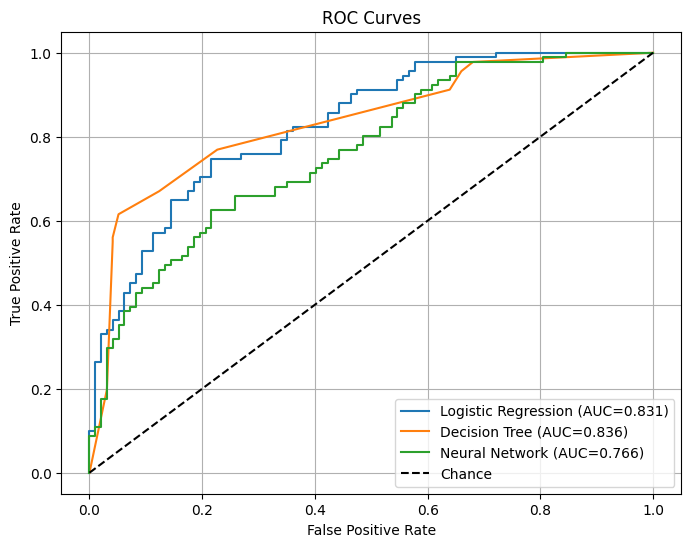

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

if "fpr_lr" not in globals():
    y_prob_lr = pipe_lr.predict_proba(X_test)[:, 1]
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
    auc_lr = roc_auc_score(y_test, y_prob_lr)

if "fpr_dt" not in globals():
    y_prob_dt = pipe_dt.predict_proba(X_test)[:, 1]
    fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
    auc_dt = roc_auc_score(y_test, y_prob_dt)

if "fpr_nn" not in globals():
    y_prob_nn = pipe_nn.predict_proba(X_test)[:, 1]
    fpr_nn, tpr_nn, _ = roc_curve(y_test, y_prob_nn)
    auc_nn = roc_auc_score(y_test, y_prob_nn)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={auc_lr:.3f})")
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC={auc_dt:.3f})")
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC={auc_nn:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
